In [1]:
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns


In [2]:
#%load_ext rpy2.ipython

##ECS 171 FP
#1. Data preprocessing
goal:  split data into dataframe subset:

In [3]:
#load data from google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [4]:
#drive.mount('/content/gdrive')
path = '/content/chip_dataset.csv'
chip_dataset = pd.read_csv(path)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read in the dataset locally
chip_dataset = pd.read_csv('/content/chip_dataset.csv')

# drop the first column which list all the indices
chip_dataset.drop('Unnamed: 0', inplace=True, axis=1)

chip_dataset

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,NVIDIA,NaN,432.0,36.0
4850,Intel GMA 950,GPU,2005-06-01,90.0,7.0,NaN,NaN,250.0,Intel,Intel,NaN,NaN,NaN
4851,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,NVIDIA,NaN,52.8,NaN
4852,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,NVIDIA,NaN,NaN,NaN


To have a brief overview of the dataset, we want to have a look of the head of the data frame and the maxium and minimum.

In [7]:
print("Look at the head (i.e. first 5 samples/trails) of the dataframe:")
chip_dataset.head()

Look at the head (i.e. first 5 samples/trails) of the dataframe:


,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN


In [8]:
print("Look at minimum values for each attribute/feature:")
chip_dataset.min()

Look at minimum values for each attribute/feature:


Product                  3dfx Spectre 1000
Type                                   CPU
Release Date                    2000-01-01
Process Size (nm)                      0.0
TDP (W)                                1.0
Die Size (mm^2)                        1.0
Transistors (million)                  8.0
Freq (MHz)                           100.0
Foundry                                 GF
Vendor                                 AMD
FP16 GFLOPS                          10.02
FP32 GFLOPS                           12.8
FP64 GFLOPS                            3.6
dtype: object

In [9]:
print("Look at maximum values for each attribute/feature:")
chip_dataset.max()

Look at maximum values for each attribute/feature:


Product                  XGI Volari V8 Ultra
Type                                     GPU
Release Date                             NaT
Process Size (nm)                      250.0
TDP (W)                                900.0
Die Size (mm^2)                        826.0
Transistors (million)                54200.0
Freq (MHz)                            4700.0
Foundry                              Unknown
Vendor                                 Other
FP16 GFLOPS                         184600.0
FP32 GFLOPS                          40000.0
FP64 GFLOPS                          11540.0
dtype: object

We notic that the release Date is in the form of yyyy-mm-dd form, to make it easier to discuss, we firstly transform it to the years from 2000-1-1 and replace it to the [years from 2000]

In [10]:
for i in range(len(chip_dataset['Release Date'])):
  if 'Na' in chip_dataset.iat[i, 2] :
    chip_dataset.iat[i, 2] = np.NaN
  else:
    year = int(chip_dataset.iat[i, 2][0:4])-2000
    month = int(chip_dataset.iat[i, 2][5:7])/12
    day = int(chip_dataset.iat[i, 2][8:10])/365
    chip_dataset.iat[i, 2] = year+ month + day

In [11]:
print("Look at the head (i.e. first 5 samples/trails) of the dataframe:")
chip_dataset.head()

Look at the head (i.e. first 5 samples/trails) of the dataframe:


,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,7.221461,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,18.766438,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Core i5-1145G7,CPU,20.755479,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,Intel Xeon E5-2603 v2,CPU,13.75274,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,AMD Phenom II X4 980 BE,CPU,11.424886,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN


In [12]:
print("Look at the 'Release Date' column:")
chip_dataset['Release Date']

Look at the 'Release Date' column:


0        7.221461
1       18.766438
2       20.755479
3        13.75274
4       11.424886
          ...    
4849    11.226941
4850      5.50274
4851    10.258219
4852     3.266438
4853      8.50274
Name: Release Date, Length: 4854, dtype: object

We notice that the CPU doesn't have GFLOPS values and we decide to split the data into two subset by [Type]

#1.1 Data Spliting
First, the data is consisted with two main category :[CPU] and [GPU], and they are evaluate by different performance. We are trying to split the data into the two subset and discuss which factors are related to the chips performance and we are trying to distinguish the relationship between them.

In [13]:
grouped = chip_dataset.groupby(chip_dataset['Type'])

# spilt and get the CPU dataset
CPU = grouped.get_group('CPU')
del CPU['FP16 GFLOPS']
del CPU['FP32 GFLOPS']
del CPU['FP64 GFLOPS']

# split and get the GPU dataset
GPU = grouped.get_group('GPU')

In [14]:
# take a look at the CPU dataset
CPU

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,CPU,7.221461,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD
1,AMD Athlon 200GE,CPU,18.766438,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD
2,Intel Core i5-1145G7,CPU,20.755479,10.0,28.0,NaN,NaN,2600.0,Intel,Intel
3,Intel Xeon E5-2603 v2,CPU,13.75274,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel
4,AMD Phenom II X4 980 BE,CPU,11.424886,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD
...,...,...,...,...,...,...,...,...,...,...
2187,Intel Xeon Gold 6312U,CPU,21.349772,10.0,185.0,NaN,NaN,2400.0,Intel,Intel
2188,AMD Ryzen 9 4900H,CPU,20.293836,7.0,54.0,156.0,9800.0,3300.0,TSMC,AMD
2189,Intel Core 2 Duo E6550,CPU,7.586073,65.0,65.0,143.0,291.0,2333.0,Intel,Intel
2190,AMD Opteron 246,CPU,5.00274,90.0,85.0,NaN,106.0,2000.0,Unknown,AMD


In [15]:
# take a look at the GPU dataset
GPU

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
2192,Intel Xeon E3-1275,GPU,11.341553,32.0,95.0,216.0,1160.0,100.0,Intel,Intel,NaN,NaN,NaN
2193,Matrox Parhelia 128 MB,GPU,2.568493,150.0,NaN,174.0,80.0,200.0,UMC,Other,NaN,NaN,NaN
2194,NVIDIA GeForce MX150 GP107,GPU,19.22968,14.0,25.0,132.0,3300.0,1469.0,Samsung,NVIDIA,18.38,1177.0,36.77
2195,Intel GMA 500,GPU,8.255479,130.0,NaN,NaN,NaN,200.0,Intel,Intel,NaN,12.8,NaN
2196,ATI Radeon HD 4350 AGP,GPU,8.832192,55.0,20.0,73.0,242.0,600.0,TSMC,ATI,NaN,96.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NVIDIA Quadro 3000M,GPU,11.226941,40.0,75.0,332.0,1950.0,450.0,TSMC,NVIDIA,NaN,432.0,36.00
4850,Intel GMA 950,GPU,5.50274,90.0,7.0,NaN,NaN,250.0,Intel,Intel,NaN,NaN,NaN
4851,NVIDIA GeForce GT 320M,GPU,10.258219,40.0,23.0,100.0,486.0,500.0,TSMC,NVIDIA,NaN,52.8,NaN
4852,NVIDIA GeForce FX 5200,GPU,3.266438,150.0,NaN,65.0,29.0,250.0,TSMC,NVIDIA,NaN,NaN,NaN


In [16]:
#First we want to know the data length of each category:
print("Display number of rows and columns of the CPU dataframe:")
display(CPU.shape)

print("\nDisplay number of rows and columns of the GPU dataframe:")
display(GPU.shape)

print("\nLook at the head (i.e. first 5 samples/trails) of the CPU dataframe:")
CPU.head()

Display number of rows and columns of the CPU dataframe:


(2192, 10)


Display number of rows and columns of the GPU dataframe:


(2662, 13)


Look at the head (i.e. first 5 samples/trails) of the CPU dataframe:


,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,CPU,7.221461,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD
1,AMD Athlon 200GE,CPU,18.766438,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD
2,Intel Core i5-1145G7,CPU,20.755479,10.0,28.0,NaN,NaN,2600.0,Intel,Intel
3,Intel Xeon E5-2603 v2,CPU,13.75274,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel
4,AMD Phenom II X4 980 BE,CPU,11.424886,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD


In [17]:
print("Look at the head (i.e. first 5 samples/trails) of the GPU dataframe:")
GPU.head()

Look at the head (i.e. first 5 samples/trails) of the GPU dataframe:


,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
2192,Intel Xeon E3-1275,GPU,11.341553,32.0,95.0,216.0,1160.0,100.0,Intel,Intel,NaN,NaN,NaN
2193,Matrox Parhelia 128 MB,GPU,2.568493,150.0,NaN,174.0,80.0,200.0,UMC,Other,NaN,NaN,NaN
2194,NVIDIA GeForce MX150 GP107,GPU,19.22968,14.0,25.0,132.0,3300.0,1469.0,Samsung,NVIDIA,18.38,1177.0,36.77
2195,Intel GMA 500,GPU,8.255479,130.0,NaN,NaN,NaN,200.0,Intel,Intel,NaN,12.8,NaN
2196,ATI Radeon HD 4350 AGP,GPU,8.832192,55.0,20.0,73.0,242.0,600.0,TSMC,ATI,NaN,96.0,NaN


Interpretation of the CPU dataset: The data [CPU] contains 2192 observations with 9 variables.
The data [CPU] contains 2662 ovservations with 13 variables,which are:

1.   Product: the product name of the chip.
2.  Type: whether the given chip is a CPU or GPU.
3.  Release Data: release data of the product. 
4.  Process Size (nm): physical size of the components that makes up a chip/product measured in nm.
5.  TDP (W): thermal design point of the product measured in W.
6.  Die Size (mm^2): physical dimension of bare die measured in mm^2.
7.  Transistors (million): number of transistors represented in unit of million.
8.  Freq (MHz): frequency measured in MHz.
9.  Foundry: company that makes the CPU/GPU.
10. Vendor: seller of the CPU/GPU.

In [18]:
CPU.columns.values

array(['Product', 'Type', 'Release Date', 'Process Size (nm)', 'TDP (W)',
       'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)',
       'Foundry', 'Vendor'], dtype=object)

Interpretation of the GPU dataset: The data [GPU] contains 2192 observations with 9 variables.
The data [GPU] contains 2662 ovservations with 13 variables,which are:

1.   Product: the product name of the chip.
2.  Type: whether the given chip is a CPU or GPU.
3.  Release Data: release data of the product. 
4.  Process Size (nm): physical size of the components that makes up a chip/product measured in nm.
5.  TDP (W): thermal design point of the product measured in W.
6.  Die Size (mm^2): physical dimension of bare die measured in mm^2.
7.  Transistors (million): number of transistors represented in unit of million.
8.  Freq (MHz): frequency measured in MHz.
9.  Foundry: company that makes the CPU/GPU.
10. Vendor: seller of the CPU/GPU.
11. FP16 GFLOPS: represent storage of weights, activations, and gradients during training iterations
12. FP32 GFLOPS: store values with larger range and higher precision than FP16 GFLOPS.
13. FP64 GFLOPS: store values with larger range and higher precision than FP32 GFLOPS.

In [20]:
GPU.columns.values

array(['Product', 'Type', 'Release Date', 'Process Size (nm)', 'TDP (W)',
       'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)',
       'Foundry', 'Vendor', 'FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS'],
      dtype=object)

In [ ]:
# data normalization for CPU dataset
from sklearn.preprocessing import MinMaxScaler
CPU_normal = CPU.copy().drop(columns=['Product','Type','Foundry','Vendor'])
scaler = MinMaxScaler()
scaler.fit(CPU_normal)
fit = scaler.fit_transform(CPU_normal)
# fit = pd.DataFrame(fit, columns = CPU_normal.columns)
final = pd.DataFrame(data = fit, columns = CPU_normal.columns, index = CPU_normal.index)
CPU_normal = CPU.copy().drop(columns=CPU_normal.columns).join(final)
CPU_normal

In [ ]:
#data normalization for GPU dataset
from sklearn.preprocessing import MinMaxScaler
GPU_normal = GPU.copy().drop(columns=['Product','Type','Foundry','Vendor'])
scaler = MinMaxScaler()
scaler.fit(GPU_normal)
fit = scaler.fit_transform(GPU_normal)

#add back to the dataframe
final = pd.DataFrame(data = fit, columns = GPU_normal.columns, index = GPU_normal.index)
#GPU_normal = GPU.copy().drop(columns=GPU_normal.columns).join(final)
GPU_normal

In [ ]:
display(CPU.Foundry.unique())
display(CPU.Vendor.unique())
display(GPU.Foundry.unique())
display(GPU.Vendor.unique())

We found there are mainly four different Foundry of the CPU and with the Vendors are AMD and Intel. The Foundry of GPU are Intel UMC Samsung TSMC Renesas GF Sony NEC and IBM, the Vendor are mainly in Intel NVIDIA ATI and AMD.

We found there are high correlation between this two variable,(A single Foundry usually only hs one corresponding Vendor.So next we will be focus more on Vendor and we will replace the name of it to the number for ml.

In [ ]:
CPU['Vendor'] = CPU['Vendor'].replace(['AMD', 'Intel'], ['0', '1'])
GPU['Vendor'] = GPU['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], ['0', '1','2','3','4'])

##2.1 First Model building and evaluation
We will first start with linear regression to see if we could recover any type of relationship between the variables and transistors.

Because the Moore's law stated that the number of transistors in a dense integrated circuit (IC) doubles about every two years, we will first focus on building an linear regression model to explain how could that be interpet on our dataset.

In [ ]:
#Here we will use y= number of transistors and x to be other variable
CPU_normal = CPU_normal.dropna()
#CPU.drop('Transistor')
X = CPU_normal. iloc[:, [4,5,6,7,9]]
y = CPU_normal. iloc[:, [8]]

X.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X['Release Date'], y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train = X_train.reshape(-1, 1)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

plt.scatter(X_train, y_train, color='red')
plt.plot(X_train, lin_reg.predict(X_train),color='blue')
plt.title("Regression model(Linear)")
plt.xlabel('Years since 2000')
plt.ylabel('Transistor')
plt.show()

lin_reg_yhat_train = lin_reg.predict(X_train)
lin_reg_yhat_test = lin_reg.predict(X_test.reshape(-1, 1))

In [ ]:
# polynomial regression of degree 2
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly, y_train)
 
X_grid = np.arange(min(X_train),max(X_train),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X_train, y_train, color='red') 
 
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
 
plt.title("Regression model(Polynomial)")
plt.xlabel('Years since 2000')
plt.ylabel('Transistor')
plt.show()

In [ ]:
# polynomial regression of degree 3
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

lin_reg3 = LinearRegression()
lin_reg3.fit(X_poly, y_train)
 
X_grid = np.arange(min(X_train),max(X_train),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X_train, y_train, color='red') 
 
plt.plot(X_grid, lin_reg3.predict(poly_reg.fit_transform(X_grid)),color='blue') 
 
plt.title("Regression model(Polynomial)")
plt.xlabel('Years since 2000')
plt.ylabel('Transistor')
plt.show()

We stop at polynomial of degree 3 for predicting transistor number using release date (i.e. years since 2000). Since there is no noticable changes on the curve on the graph which we observe above. 

We will calcuate the SSE/SSR which is the percentage of variation that coud be explain by the linear regression model

From the model we found the time and Transistor is obviously not in a linear relation. The Moore's law predict there are log() relationship between these two variable. So we are trying to transform the data in to x'=log(x) and re-construct the linear regression model

In [ ]:
rmse = np.sqrt(mean_squared_error(y_train, lin_reg_yhat_train))
r2 = r2_score(y_train, lin_reg_yhat_train)
print('Training RMSE: %8.15f' % rmse)
print('Training R2: %8.15f' % r2)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, lin_reg_yhat_test))
r2 = r2_score(y_test, lin_reg_yhat_test)
print('Testing RMSE: %8.15f' % rmse)
print('Testing R2: %8.15f' % r2)

Using knowledge from statistic, We know the R2 value is the proportion of the variation in the dependent variable that is predictable from the independent variables. Here, both the R2 and the adjusted R2 value are very high, which means that almost all the variation in Transistors can be explained by the independent variables on the Release Date.

### 3.1 ANN Brand Prediction

In [67]:
y = CPU['Vendor']
y


0       0
1       0
2       1
3       1
4       0
       ..
2187    1
2188    0
2189    1
2190    0
2191    0
Name: Vendor, Length: 2192, dtype: object

In [68]:
X=CPU_normal.copy().drop(['Vendor', 'Foundry','Product','Type'],axis=1)
y = CPU_normal['Vendor'].replace(['AMD', 'Intel'], [0, 1])
X.shape
y.shape

(1543,)

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=5)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train

(1234, 6) (1234,)
(309, 6) (309,)


1768    0
1317    1
1591    0
1224    0
1310    0
       ..
2009    0
1608    1
1413    1
298     0
1227    1
Name: Vendor, Length: 1234, dtype: int64

In [71]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(units =6, activation = 'relu', input_dim = 6))
model.add(Dense(units = 6, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.fit(X_train, y_train, batch_size = 1, epochs = 10)

Epoch 1/10
1234/1234 [==============================] - 2s 1ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 2/10
1234/1234 [==============================] - 2s 1ms/step - loss: 0.6921 - accuracy: 0.5186
Epoch 3/10
1234/1234 [==============================] - 2s 2ms/step - loss: 0.6899 - accuracy: 0.5316
Epoch 4/10
1234/1234 [==============================] - 3s 2ms/step - loss: 0.6864 - accuracy: 0.5810
Epoch 5/10
1234/1234 [==============================] - 3s 2ms/step - loss: 0.6831 - accuracy: 0.6005
Epoch 6/10
1234/1234 [==============================] - 3s 2ms/step - loss: 0.6768 - accuracy: 0.6070
Epoch 7/10
1234/1234 [==============================] - 2s 2ms/step - loss: 0.6684 - accuracy: 0.6337
Epoch 8/10
1234/1234 [==============================] - 2s 2ms/step - loss: 0.6555 - accuracy: 0.6580
Epoch 9/10
1234/1234 [==============================] - 2s 2ms/step - loss: 0.6317 - accuracy: 0.6823
Epoch 10/10
1234/1234 [==============================] - 2s 1ms/step - loss: 0.602

In [62]:
from sklearn.naive_bayes import CategoricalNB
model = CategoricalNB()
model.fit(X_train, y_train)
yhat_test = model.predict(X_test)

Epoch 1/50
278/278 [==============================] - 1s 5ms/step - loss: 0.3247 - accuracy: 0.8532 - val_loss: 0.4738 - val_accuracy: 0.7823
Epoch 2/50
278/278 [==============================] - 1s 3ms/step - loss: 0.3262 - accuracy: 0.8559 - val_loss: 0.4331 - val_accuracy: 0.8065
Epoch 3/50
278/278 [==============================] - 1s 2ms/step - loss: 0.3271 - accuracy: 0.8514 - val_loss: 0.4022 - val_accuracy: 0.8226
Epoch 4/50
278/278 [==============================] - 1s 2ms/step - loss: 0.3275 - accuracy: 0.8541 - val_loss: 0.3820 - val_accuracy: 0.8226
Epoch 5/50
278/278 [==============================] - 1s 2ms/step - loss: 0.3262 - accuracy: 0.8523 - val_loss: 0.3720 - val_accuracy: 0.8306
Epoch 6/50
278/278 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8604 - val_loss: 0.4275 - val_accuracy: 0.8226
Epoch 7/50
278/278 [==============================] - 1s 2ms/step - loss: 0.3229 - accuracy: 0.8604 - val_loss: 0.3232 - val_accuracy: 0.8306
Epoch 

<ipython-input-74-b4ea680496df>:9: MatplotlibDeprecationWarning: Unrecognized location 'upper\xa0left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['train','val'],loc='upper left')


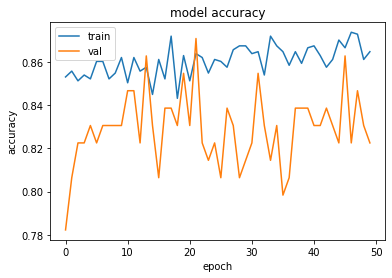

In [74]:
import keras
from matplotlib import pyplot as plt
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=500, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

array([[  1, 137],
       [  0, 171]])

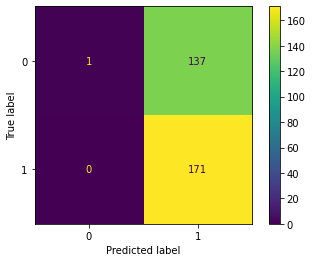

In [43]:
# Let's create our confusion matrix and display it
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yhat_test = model.predict(X_test)
myconfusionmatrix = confusion_matrix(y_test, yhat_test)
display(myconfusionmatrix)
mycmdisp = ConfusionMatrixDisplay(confusion_matrix=myconfusionmatrix, display_labels=model.classes_)
mycmdisp.plot()

### 3.2 ANN prediction for GPUs

In [117]:
a =GPU.dropna()
y = a['Vendor'].replace(['AMD', 'Intel', 'Other', 'NVIDIA', 'ATI'], [0, 1, 2, 3, 4])
y

2194    3
2204    0
2211    3
2217    0
2223    0
       ..
4802    0
4803    3
4830    0
4836    0
4840    3
Name: Vendor, Length: 413, dtype: object

In [118]:
X = a.copy().drop(['Vendor', 'Foundry','Product','Type'],axis=1)
# X = (X-X.min())/(X.max()-X.min())
X

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
2194,19.22968,14.0,25.0,132.0,3300.0,1469.0,18.38,1177.0,36.77
2204,20.910046,7.0,250.0,520.0,26800.0,1700.0,32330.00,16170.0,1010.00
2211,18.323973,12.0,250.0,815.0,21100.0,1290.0,31330.00,15670.0,7834.00
2217,15.957763,28.0,15.0,125.0,1200.0,200.0,737.30,737.3,368.60
2223,19.285616,14.0,150.0,232.0,5700.0,1074.0,4394.00,4394.0,274.60
...,...,...,...,...,...,...,...,...,...
4802,16.915525,14.0,35.0,123.0,3000.0,850.0,1858.00,1858.0,116.10
4803,17.185845,14.0,47.0,132.0,3300.0,1354.0,22.27,1425.0,44.54
4830,18.36347,14.0,50.0,103.0,2200.0,1100.0,1505.00,1505.0,94.08
4836,17.573973,14.0,300.0,495.0,12500.0,1400.0,24580.00,12290.0,768.00


In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=5)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train.unique()

(330, 9) (330,)
(83, 9) (83,)


array(['3', '0', '1'], dtype=object)

In [120]:
X_train
# X_train.loc[(X_train!=0).any(axis=1)]
X_train.astype('float32')


,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
3842,19.396347,12.0,75.0,200.0,4700.0,1485.0,5967.000000,2984.0,93.239998
4282,16.347033,16.0,300.0,610.0,15300.0,1328.0,21220.000000,10610.0,5304.000000
4160,19.169407,14.0,75.0,132.0,3300.0,1366.0,34.610001,2215.0,69.220001
2792,19.162785,12.0,90.0,545.0,13600.0,735.0,12890.000000,6447.0,201.500000
4724,17.183105,16.0,105.0,314.0,7200.0,1202.0,82.879997,5304.0,165.800003
...,...,...,...,...,...,...,...,...,...
4772,20.140867,7.0,150.0,251.0,10300.0,1130.0,12780.000000,6390.0,399.399994
2904,18.169407,14.0,40.0,132.0,3300.0,1177.0,23.090000,1478.0,46.180000
3396,16.707762,16.0,80.0,200.0,4400.0,1404.0,66.800003,4275.0,133.600006
3516,20.602512,7.0,150.0,251.0,10300.0,1035.0,11660.000000,5829.0,364.299988


In [124]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(units =6, activation = 'relu', input_dim = 9))
model.add(Dense(units = 6, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.fit(X_train.astype('float32'), y_train.astype('float32'), batch_size = 1, epochs = 50)

Epoch 1/50
330/330 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 2/50
330/330 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 3/50
330/330 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 4/50
330/330 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 5/50
330/330 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 6/50
330/330 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 7/50
330/330 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 8/50
330/330 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 9/50
330/330 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 10/50
330/330 [==============================] - 1s 2ms/st

Epoch 1/50
75/75 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - acc

<ipython-input-122-738a7c8cbd82>:9: MatplotlibDeprecationWarning: Unrecognized location 'upper\xa0left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['train','val'],loc='upper left')


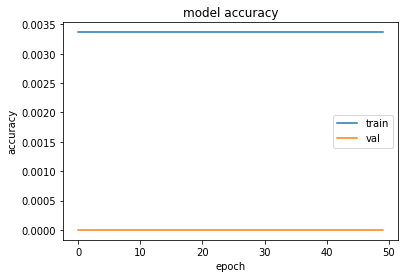

In [122]:
import keras
from matplotlib import pyplot as plt
history = model.fit(X_train.astype('float32'), y_train.astype('float32'),validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()